## Data acquisition and processing

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from esios import *

### 1. Download data using ESIOS.py 

#### Dictionary with Indicator Name and Number of Indicator

In [2]:
indicatorsDict = {
                    'demand': 460,
                    'price': 805,
                    'wind':541,
                    'solar':10034
                 }

indicatorsItems = indicatorsDict.items()   # To iterate over name and number at the same time

#### Download indicators data from 01-01-2014 to 01-06-2020 and save it into `".csv"` files.

In [3]:
start_date = "2010-01-01"
end_date = "2020-07-01"
start_ = start_date + 'T00:00:00'
end_ = end_date + 'T23:50:00'
token = '6cc21e0b60e9931e7522a6ce72a1a09f3a6fadc6f08b142f956db142c6858bc2'    # Introduce ESIOS token
esios = ESIOS(token)
country = 'Spain' #Spain, France or Portugal are the options

for indicatorName, indicatorValue in indicatorsItems:
    print ('Start Date: ' + start_date)
    print ('End Date: ' + end_date)
    indicators_ = list()
    indicators_.append(indicatorValue)
    dfmul , df_list, names = esios.get_multiple_series(indicators_, start_, end_, country)
    df = dfmul[names]
    df = df.reset_index()
    df.columns = ['Date', indicatorName]
    df['Date'] = df['Date'].str.replace('.', ' ')
    df['Date'] = df['Date'].str.split().str[0]
    df['Date'] = df['Date'].str.replace('T', ' ')
    # Export to .csv file
    try:
        os.stat("Files/")
    except:
        os.mkdir("Files/")
    df.to_csv(path_or_buf= 'Files/' + str(indicatorName) + '.csv', sep='^', index=False)
    print('Generated:' + str(indicatorName))

Analyzing indicators...
Start Date: 2010-01-01
End Date: 2020-07-01
Generated:demand
Start Date: 2010-01-01
End Date: 2020-07-01
Generated:price
Start Date: 2010-01-01
End Date: 2020-07-01
Generated:wind
Start Date: 2010-01-01
End Date: 2020-07-01
Generated:solar


### 2. Preprocesing bank holidays

In [4]:
df_holidays = pd.read_csv('Files/Bank_Holidays_Final.csv', sep = '^')
df_holidays['Date'] =pd.to_datetime(df_holidays['Date'])

### 3. Preprocesing esios data

In [5]:
from functools import reduce

In [6]:
with open('Files/demand.csv', 'r') as fichero:     
    dfDemand = pd.read_csv(fichero, sep = '^', dtype='object')
    dfDemand['Date']=pd.to_datetime(dfDemand['Date'])
    
with open('Files/solar.csv', 'r') as fichero:     
    dfSolar = pd.read_csv(fichero, sep = '^', dtype='object')
    dfSolar['Date']=pd.to_datetime(dfSolar['Date']) 
    
with open('Files/wind.csv', 'r') as fichero:     
    dfWind = pd.read_csv(fichero, sep = '^', dtype='object')
    dfWind['Date']=pd.to_datetime(dfWind['Date'])
    
with open('Files/price.csv', 'r') as fichero:     
    dfPrice = pd.read_csv(fichero, sep = '^', dtype='object')
    dfPrice['Date']=pd.to_datetime(dfPrice['Date']) 

#### Merge all files in one DataFrame

#### It's necessary to drop duplicates values to avoid repeated rows before merging DataFrames. 

In [7]:
dfDemand = dfDemand.drop_duplicates(subset='Date', keep='first')
dfSolar = dfSolar.drop_duplicates(subset='Date', keep='first')
dfWind = dfWind.drop_duplicates(subset='Date', keep='first')
dfPrice = dfPrice.drop_duplicates(subset='Date', keep='first')

In [8]:
df_esios = [dfDemand, dfSolar, dfWind, dfPrice]
df_esios = reduce(lambda left,right: pd.merge(left,right,on='Date', how = 'right'), df_esios)
df_esios.head(3)

,Date,demand,solar,wind,price
0,2014-01-01 00:00:00,26252.0,3.5,10790.0,20.02
1,2014-01-01 01:00:00,24040.0,0.0,10885.0,10.34
2,2014-01-01 02:00:00,22829.0,0.0,10984.0,5.35


#### Is needed to cast objects to floats

In [9]:
df_esios.dtypes

Date      datetime64[ns]
demand            object
solar             object
wind              object
price             object
dtype: object

In [10]:
df_esios['demand'] = df_esios['demand'].astype(float)
df_esios['solar'] = df_esios['solar'].astype(float)
df_esios['wind'] = df_esios['wind'].astype(float)
df_esios['price'] = df_esios['price'].astype(float)

In [11]:
df_esios.dtypes

Date      datetime64[ns]
demand           float64
solar            float64
wind             float64
price            float64
dtype: object

#### Check data distribution using seaborn boxplot

In [12]:
import seaborn as sns
import matplotlib.dates as dates
import matplotlib.pyplot as plt
%matplotlib inline 

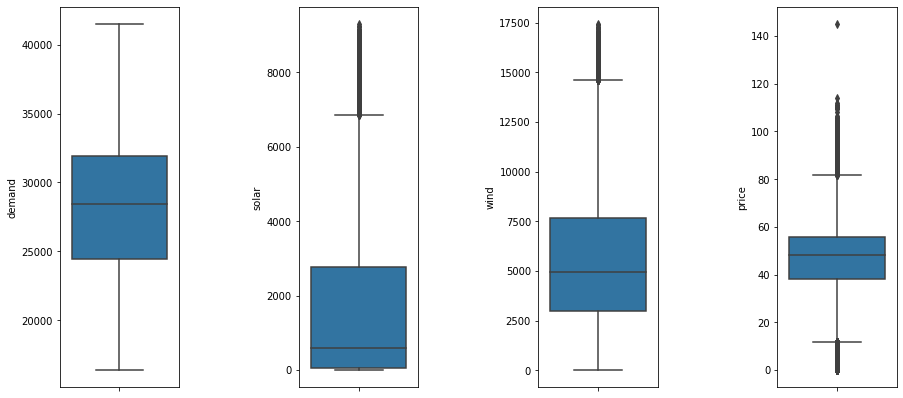

In [13]:
fig, axs = plt.subplots(ncols=4,figsize=(15,7))
plt.subplots_adjust(wspace=1, hspace=None)
sns.boxplot(df_esios['demand'], orient='v', ax=axs[0])
sns.boxplot(df_esios['solar'], orient='v', ax=axs[1])
sns.boxplot(df_esios['wind'], orient='v', ax=axs[2])
sns.boxplot(df_esios['price'], orient='v', ax=axs[3])
plt.show()

#### 2a. OUTLIERS

In [14]:
df_esios.describe()

,demand,solar,wind,price
count,56969.000000,56969.000000,56969.00000,92029.000000
mean,28341.512559,1530.728180,5606.23282,45.931074
std,4639.590215,1826.435406,3310.03786,15.834725
min,16372.000000,0.000000,12.60000,0.000000
25%,24450.000000,59.600000,3008.00000,38.100000
50%,28435.000000,585.700000,4960.00000,48.000000
75%,31912.000000,2776.600000,7645.00000,55.560000
max,41514.000000,9299.000000,17430.00000,145.000000


Calculate Interquantile range as the difference between upper and lower quartiles (IQR = Q3 - Q1)



In [15]:
Q1 = df_esios.quantile(0.25)
Q3 = df_esios.quantile(0.75)
IQR = Q3 - Q1
IQR

demand    7462.00
solar     2717.00
wind      4637.00
price       17.46
dtype: float64

Calculate the number of outliers for each DataFrame 'df_esios' series.

#### 'DEMAND' Outliers:


In [16]:
numOutliersQ1_D = df_esios['demand'][df_esios['demand']<(Q1.iloc[0] - 1.5 * IQR.iloc[0])].count()
numOutliersQ3_D = df_esios['demand'][df_esios['demand']>(Q3.iloc[0] + 1.5 * IQR.iloc[0])].count()
numOutliersDemand = numOutliersQ1_D + numOutliersQ3_D
numOutliersDemand

0

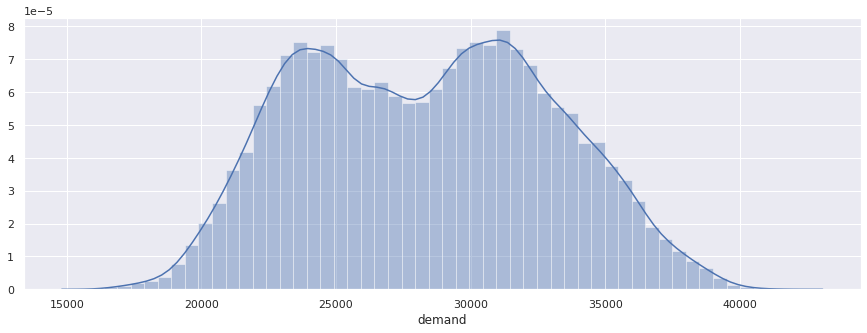

In [17]:
sns.set(rc={"figure.figsize": (15, 5)})
sns.distplot(df_esios['demand'])
plt.show()

#### 'SOLAR' Outliers:


In [18]:
numOutliersQ1_S = df_esios['solar'][df_esios['solar']<(Q1.iloc[1] - 1.5 * IQR.iloc[1])].count()
numOutliersQ3_S = df_esios['solar'][df_esios['solar']>(Q3.iloc[1] + 1.5 * IQR.iloc[1])].count()
numOutliersSolar = numOutliersQ1_S + numOutliersQ3_S
numOutliersSolar

403

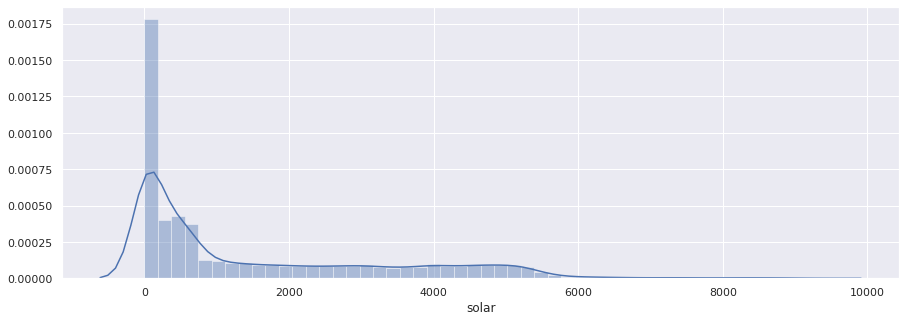

In [45]:
sns.set(rc={"figure.figsize": (15, 5)})
sns.distplot(df_esios['solar'])
plt.show()

#### 'WIND' Outliers:


In [19]:
numOutliersQ1_W = df_esios['wind'][df_esios['wind']<(Q1.iloc[2] - 1.5 * IQR.iloc[2])].count()
numOutliersQ3_W = df_esios['wind'][df_esios['wind']>(Q3.iloc[2] + 1.5 * IQR.iloc[2])].count()
numOutliersWind = numOutliersQ1_W + numOutliersQ3_W
numOutliersWind

506

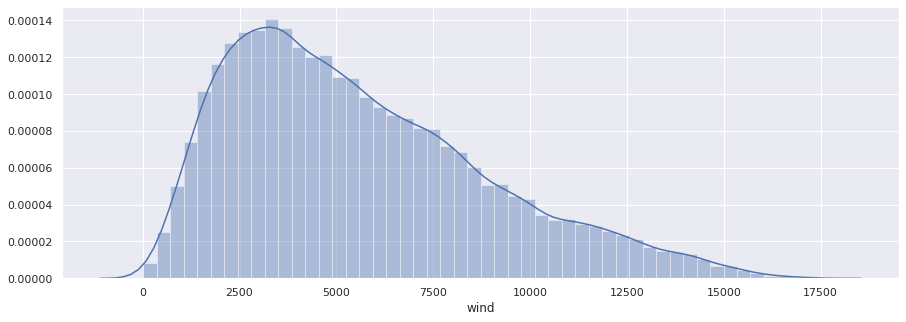

In [20]:
sns.set(rc={"figure.figsize": (15, 5)})
sns.distplot(df_esios['wind'])
plt.show()

#### 'PRICE' Outliers:


In [21]:
numOutliersQ1_P = df_esios['price'][df_esios['price']<(Q1.iloc[3] - 1.5 * IQR.iloc[3])].count()
numOutliersQ3_P = df_esios['price'][df_esios['price']>(Q3.iloc[3] + 1.5 * IQR.iloc[3])].count()
numOutliersPrice = numOutliersQ1_P + numOutliersQ3_P
numOutliersPrice

4459

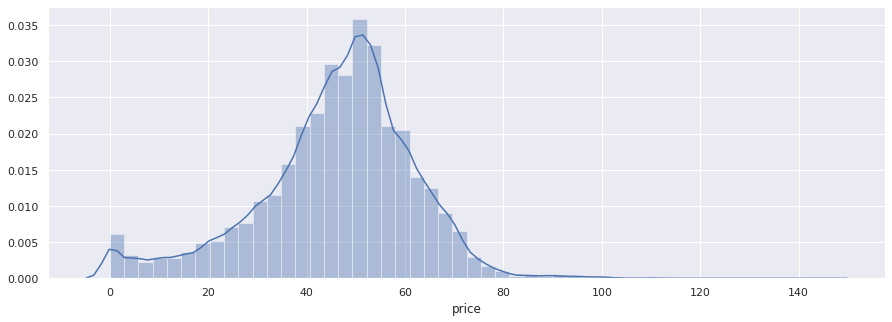

In [22]:
sns.set(rc={"figure.figsize": (15, 5)})
sns.distplot(df_esios['price'])
plt.show()

In 'demand' series -> 0 outliers.<br>
In 'solar' series -> 403 outliers(0.707% of data are outliers).<br>
In 'wind' series -> 506 outliers (0,888% of data are outliers).<br>
In 'price' series -> 1609 outliers (2.814% of data are outliers).<br>

#### 3. Merge DataFrames

In [23]:
df_merge = [df_holidays, df_esios]

In [24]:
data = reduce(lambda left,right: pd.merge(left,right,on='Date'), df_merge)
data.head()

,Date,Holiday,Weekend,demand,solar,wind,price
0,2014-01-01 00:00:00,1,0,26252.0,3.5,10790.0,20.02
1,2014-01-01 01:00:00,1,0,24040.0,0.0,10885.0,10.34
2,2014-01-01 02:00:00,1,0,22829.0,0.0,10984.0,5.35
3,2014-01-01 03:00:00,1,0,21816.0,0.5,10680.0,5.00
4,2014-01-01 04:00:00,1,0,21439.0,2.2,10605.0,0.50


In [25]:
data['Hour'] = data['Date'].dt.hour
data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month
data['Weekday'] = data['Date'].dt.weekday

In [26]:
data.head()

,Date,Holiday,Weekend,demand,solar,wind,price,Hour,Day,Month,Weekday
0,2014-01-01 00:00:00,1,0,26252.0,3.5,10790.0,20.02,0,1,1,2
1,2014-01-01 01:00:00,1,0,24040.0,0.0,10885.0,10.34,1,1,1,2
2,2014-01-01 02:00:00,1,0,22829.0,0.0,10984.0,5.35,2,1,1,2
3,2014-01-01 03:00:00,1,0,21816.0,0.5,10680.0,5.00,3,1,1,2
4,2014-01-01 04:00:00,1,0,21439.0,2.2,10605.0,0.50,4,1,1,2


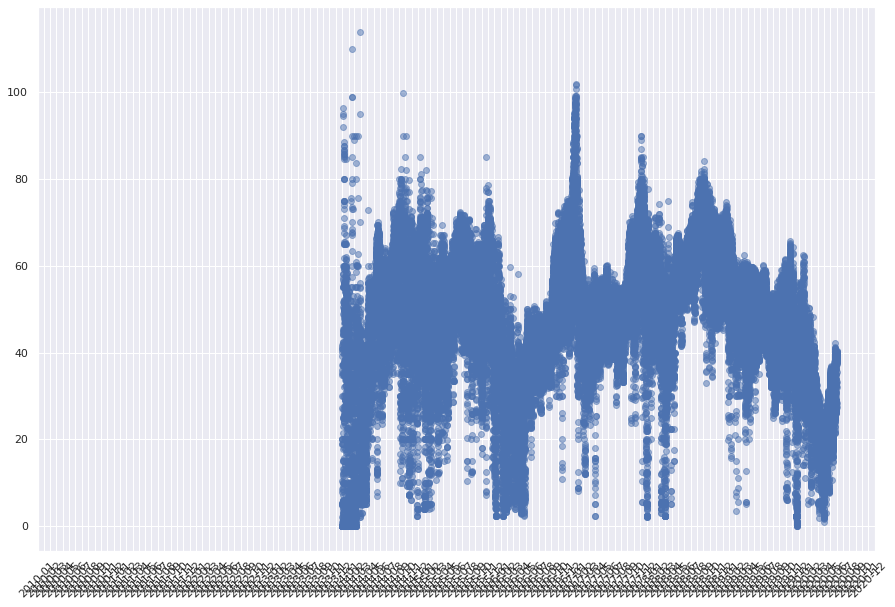

In [27]:
ax = plt.figure(figsize=(15,10)).add_subplot(111)
plt.scatter(data['Date'].tolist(), data['price'],alpha=0.5) 
plt.xlim([datetime.date(2010, 1, 1), datetime.date(2020, 12, 31)])
ax.xaxis.set_major_locator(dates.MonthLocator())
hfmt = dates.DateFormatter('%Y-%m')
ax.xaxis.set_major_formatter(hfmt)
plt.xticks(rotation=45)
plt.show()

In [28]:
data.to_csv('Data.csv', sep = '^', index = False)